# Stanford Background Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing import image
  
from sklearn.model_selection import train_test_split
import random
import os 
from PIL import Image 
from google.colab import drive 

import pickle
from tensorflow.keras.utils import plot_model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Background/Background.zip'

Стэнфордский фоновый набор данных был представлен в работе Gould et al. (ICCV 2009) для оценки методов геометрического и семантического понимания сцены. Набор данных содержит 715 изображений, выбранных из общедоступных наборов данных: LabelMe, MSRC, PASCAL VOC и Geometric Context. Критерии отбора состояли в том, что изображения представляли собой наружные сцены, имеющие приблизительно 320 на 240 пикселей, содержащие по крайней мере один объект переднего плана и имеющие положение горизонта внутри изображения (оно не обязательно должно быть видимым).

https://www.kaggle.com/balraj98/stanford-background-dataset?select=labels_colored

In [ ]:
x_path = '/content/images/'
y_path = '/content/labels/'

In [ ]:
img_width = 240 # Ширина картинки 
img_height =  320 # Высота картинки 
num_classes = 9 # Количество классов

In [ ]:
#Записываем картинки в массивы
X=[]
y=[]
for file in sorted(os.listdir(x_path)):
  img_pic = image.load_img((x_path + file), target_size=(img_width,img_height))
  X.append(image.img_to_array(img_pic))

for file in sorted(os.listdir(y_path)):
  img_mask = image.load_img((y_path + file), target_size=(img_width,img_height))
  y.append(image.img_to_array(img_mask))

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (9 классов)
def color_to_index(color):
  index=0 
  if (color[0]==68)and(color[1]==1)and(color[2]==84) : index=1 # небо
  elif (color[0]==72)and(color[1]==40)and(color[2]==140) : index=2 # дерево
  elif (color[0]==62)and(color[1]==74)and(color[2]==137) : index=3 # дорога
  elif (color[0]==38)and(color[1]==130)and(color[2]==142) : index=4 # трава
  elif (color[0]==31)and(color[1]==158)and(color[2]==137) : index=5 # вода
  elif (color[0]==53)and(color[1]==183)and(color[2]==121) : index=6 # дома
  elif (color[0]==109)and(color[1]==205)and(color[2]==89) : index=7 # горы
  elif (color[0]==180)and(color[1]==222)and(color[2]==44) : index=8 # передний план
  elif (color[0]==49)and(color[1]==104)and(color[2]==142) : index=9 # остальное
  return index  


In [ ]:
# Функция возвращает цвет пикселя по классу
def index_to_color(index):
    index = np.argmax(index)
    color=[]
    if index == 0:
      color = [0, 0, 0]  
    elif index == 1:
      color = [68, 1, 84]  
    elif index == 2:
      color = [72, 40, 140]
    elif index == 3:
      color = [62, 74, 137]
    elif index == 4:
      color = [38, 130, 142]
    elif index == 5:
      color = [31, 158, 137]
    elif index == 6:
      color = [53, 183, 121]
    elif index == 7: 
      color = [109, 205, 89]
    elif index == 8: 
      color = [180, 222, 44]
    elif index == 9:    
      color = [49, 104, 142]         
    return color 

In [ ]:
# Функция переводит индекс класса в OneHotEncoding
def color_to_ohe(y, num_classes): 
  y_shape = y.shape # Сохраняем размер входного массива
  y = y.reshape(y_shape[0] * y_shape[1], 3) # Переводим в двумерный массив
  y_ohe = [] # Создаем пустой лист
  for i in range(len(y)):
    y_ohe.append(to_categorical(color_to_index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  y_ohe = np.array(y_ohe)
  y_ohe = y_ohe.reshape(y_shape[0], y_shape[1], num_classes) # Возвращаем к исходныму размеру
  return y_ohe 

In [ ]:
# Функция преобразует маску в метку для сегментации
def transform_y(data, num_classes):
  y_train = [] # Создаем пустой список под карты сегметации
  for img in y: 
    label = color_to_ohe(img, num_classes) 
    y_train.append(label) 
  return np.array(y_train) 

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 5, n_classes = 9):
  indexes = np.random.randint(0, len(x_test), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(x_test[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = y_test[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index_to_color(pr[k])) # Переводим индекс в писксель
      pr2.append(index_to_color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[2,i].imshow(Image.fromarray(x_test[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

In [ ]:
#Преобразуем данные к заданным индексам
X = np.array(X)
y_transform = transform_y(y, num_classes)

In [ ]:
#Делим на обучающую и тестовую выборку
x_train, x_test, y_train, y_test = train_test_split(X, y_transform, test_size=0.1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(643, 240, 320, 3)
(643, 240, 320, 9)
(72, 240, 320, 3)
(72, 240, 320, 9)


In [ ]:
#Функция считает степень пересечения настоящей и рпедсказанной маски
def dice_coef(true, pred):
  return (2 * K.sum(true*pred)+1) / (K.sum(true) + K.sum(pred)+1)

In [ ]:
#Функция создает модель U-net
def create_model(input_shape=(240,320,3), output_class=9):
  input=Input(input_shape)

  x = Conv2D(32, (3,3), activation='elu', padding='same')(input)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x_output_1 = x
  x_output_1_conv = Conv2D(32, (3,3), activation='relu', padding='same')(x)

  x = MaxPooling2D()(x)   #120x160

  x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x_output_2 = x  
  x_output_2_conv = Conv2D(64, (3,3), activation='relu', padding='same')(x)

  x = MaxPooling2D()(x)   #60x80

  x = Conv2D(128, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x_output_3 = x
  x_output_3_conv = Conv2D(128, (3,3), activation='relu', padding='same')(x)

  x = MaxPooling2D()(x)   #30x40

  x = Conv2D(256, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x_output_4 = x
  x_output_4_conv = Conv2D(256, (3,3), activation='relu', padding='same')(x)

  x = MaxPooling2D()(x)   #15x20

  x = Conv2D(512, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(512, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  # x_output_5 = x  
  # x_output_5_conv = Conv2D(512, (3,3), activation='relu', padding='same')(x)

  x = Conv2DTranspose(256, (2,2), strides=(2,2) ,activation='relu', padding='same')(x)   #30x40
  x = BatchNormalization()(x)

  x = concatenate([x, x_output_4, x_output_4_conv])
  x = Conv2D(256, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)  

  x = Conv2DTranspose(128, (2,2), strides=(2,2) ,activation='relu', padding='same')(x)   #60x80
  x = BatchNormalization()(x)

  x = concatenate([x, x_output_3, x_output_3_conv])
  x = Conv2D(128, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)  

  x = Conv2DTranspose(64, (2,2), strides=(2,2) ,activation='relu', padding='same')(x)   #120x160
  x = BatchNormalization()(x)

  x = concatenate([x, x_output_2, x_output_2_conv])
  x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)  

  x = Conv2DTranspose(32, (2,2), strides=(2,2) ,activation='relu', padding='same')(x)   #240x320
  x = BatchNormalization()(x)

  x = concatenate([x, x_output_1, x_output_1_conv])
  x = Conv2D(32, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), activation='elu', padding='same')(x)
  x = BatchNormalization()(x) 

  output = Conv2D(output_class, (3,3), activation='softmax', padding='same')(x)  

  model = Model(input, output)
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
#Обучаем модель
model = create_model()
model.compile(optimizer=Adam(0.00001), loss='categorical_crossentropy', metrics=[dice_coef])
model.fit(x_train, y_train, epochs=10, batch_size=8, validation_data=(x_test, y_test))

Epoch 1/10
81/81 [==============================] - 28s 316ms/step - loss: 0.4498 - dice_coef: 0.7758 - val_loss: 0.4807 - val_dice_coef: 0.7654
Epoch 2/10
81/81 [==============================] - 25s 313ms/step - loss: 0.4190 - dice_coef: 0.7862 - val_loss: 0.4754 - val_dice_coef: 0.7690
Epoch 3/10
81/81 [==============================] - 25s 307ms/step - loss: 0.4327 - dice_coef: 0.7802 - val_loss: 0.4757 - val_dice_coef: 0.7701
Epoch 4/10
81/81 [==============================] - 25s 307ms/step - loss: 0.4462 - dice_coef: 0.7776 - val_loss: 0.4737 - val_dice_coef: 0.7708
Epoch 5/10
81/81 [==============================] - 25s 309ms/step - loss: 0.4362 - dice_coef: 0.7793 - val_loss: 0.4724 - val_dice_coef: 0.7717
Epoch 6/10
81/81 [==============================] - 25s 309ms/step - loss: 0.4322 - dice_coef: 0.7822 - val_loss: 0.4722 - val_dice_coef: 0.7714
Epoch 7/10
81/81 [==============================] - 25s 308ms/step - loss: 0.4386 - dice_coef: 0.7792 - val_loss: 0.4732 - val_dic

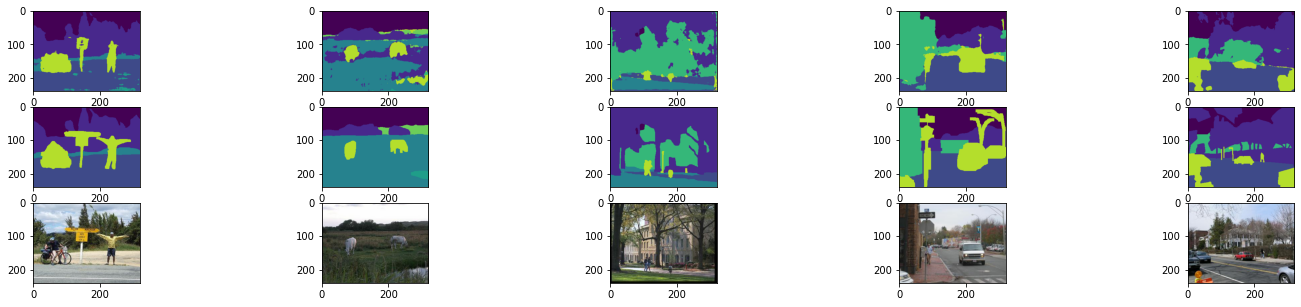

In [ ]:
#Посмотрим что получилось
processImage(model, count = 5, n_classes = 9)